# tinycodec

This notebook will track my experiments with video encoding and developing the tinycodec software/hardware codec.

**Resources**
- https://last.hit.bme.hu/download/vidtech/k%C3%B6nyvek/Iain%20E.%20Richardson%20-%20H264%20(2nd%20edition).pdf
- https://github.com/leandromoreira/digital_video_introduction
- https://en.wikipedia.org/wiki/Discrete_cosine_transform
- https://en.wikipedia.org/wiki/JPEG
- https://en.wikipedia.org/wiki/Data_compression#Video
- https://arxiv.org/pdf/1702.00817

In [189]:
import ffmpeg
import numpy as np
from matplotlib import pyplot as plt
from ipywidgets import interact
from scipy.fft import dct
from IPython.display import Math
from IPython.display import display

%matplotlib inline

In [190]:
probe = ffmpeg.probe('data/test.mov')
video_stream = next((stream for stream in probe['streams'] if stream['codec_type'] == 'video'), None)
width = int(video_stream['width'])
height = int(video_stream['height'])
fps = int(video_stream['avg_frame_rate'].split('/')[0])

In [191]:
def frame(i):
    out, _ = (
        ffmpeg
        .input('data/test.mov', ss=i/fps)
        .output('pipe:', vframes=1, format='rawvideo', pix_fmt='rgb24')
        .run(capture_stdout=True, capture_stderr=True)
    )
    return np.frombuffer(out, np.uint8).reshape([height, width, 3])

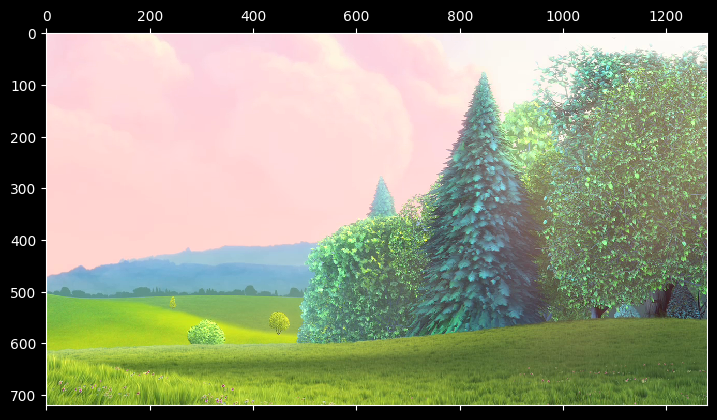

In [192]:
frame1 = frame(200)

plt.matshow(frame1)
plt.show();

In [193]:
def rgb2yuv(rgb):
    xform = np.array([[.299, .587, .114], [-.1687, -.3313, .5], [.5, -.4187, -.0813]])
    ycbcr = rgb.dot(xform.T)
    ycbcr[:,:,[1,2]] += 128
    return np.uint8(ycbcr)

In [194]:
def plot_yuv(y,u,v):
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].matshow(y, label='Y', cmap='grey')
    ax[0].title.set_text('Y')
    ax[1].matshow(u, label='U', cmap='grey')
    ax[1].title.set_text('U')
    ax[2].matshow(v, label='V', cmap='grey')
    ax[2].title.set_text('V')
    plt.show()

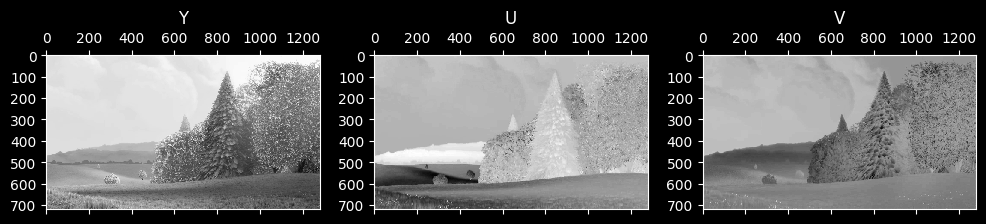

In [195]:
frame1_yuv = rgb2yuv(frame1)
plot_yuv(y=frame1_yuv[:,:,0],u=frame1_yuv[:,:,1],v=frame1_yuv[:,:,2])

In [196]:
def chroma_subsample(yuv):
    y = yuv[:,:,0]
    u = yuv[:,:,1]
    v = yuv[:,:,2]
    ud = u[::2, ::2]
    vd = v[::2, ::2]
    uu = np.repeat(np.repeat(ud, 2, axis=0), 2, axis=1)
    vu = np.repeat(np.repeat(vd, 2, axis=0), 2, axis=1)
    return np.stack((y, uu, vu), axis=-1)

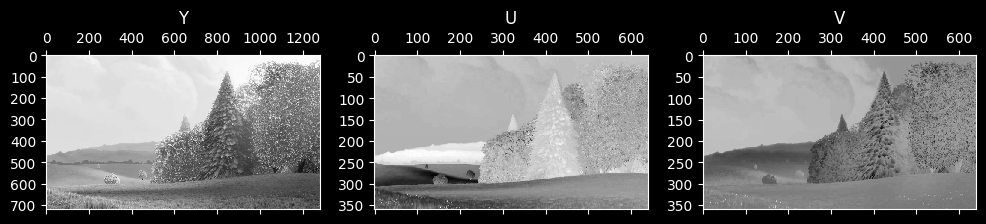

In [197]:
X = chroma_subsample(frame1_yuv)
plot_yuv(y=X[:,:,0],u=X[::2,::2,1],v=X[::2,::2,2])

In [198]:
def macroblock(x, i, j):
    return x[i*16:(i+1)*16, j*16:(j+1)*16]

In [199]:
def plot_macroblock(mb):
    fig, ax = plt.subplots(1,3, figsize=(12,4))
    ax[0].matshow(mb[:,:,0], label='Y', cmap='grey')
    ax[0].title.set_text('Y')
    ax[1].matshow(mb[::2,::2,1], label='U', cmap='grey')
    ax[1].title.set_text('U')
    ax[2].matshow(mb[::2,::2,2], label='V', cmap='grey')
    ax[2].title.set_text('V')
    plt.show()

@interact(i=(0, height//16-1), j=(0, width//16-1))
def show_macroblock(i, j):
    mb = macroblock(X, i, j)
    plot_macroblock(mb)

interactive(children=(IntSlider(value=22, description='i', max=44), IntSlider(value=39, description='j', max=7…

In [200]:
mb = macroblock(X, 22, 39)
mb.shape

(16, 16, 3)

In [201]:
def bmatrix(a):
    a = a.round(decimals=4)
    if len(a.shape) > 2:
        raise ValueError('bmatrix can at most display two dimensions')
    lines = str(a).replace('[', '').replace(']', '').splitlines()
    rv = [r'\begin{bmatrix}']
    rv += ['  ' + ' & '.join(l.split()) + r'\\' for l in lines]
    rv +=  [r'\end{bmatrix}']
    return '\n'.join(rv)

In [202]:
def dct_matrix(size):
    return dct(np.eye(size), norm='ortho').T

A = dct_matrix(8)

display(Math(f"\\begin{{align}} \\mathbf{{A}} = {bmatrix(A)} \\end{{align}}"));

<IPython.core.display.Math object>

In [203]:
def forward_dct(mb):
    """Split macroblock into 8x8 chunks and apply dct on each of them"""
    blocks = []
    A = dct_matrix(8)
    for i in range(0, 16, 8):
        for j in range(0, 16, 8):
            block = mb[i:i+8, j:j+8]
            blocks.append(A @ block @ A.T)
    return np.block([[blocks[0], blocks[1]], [blocks[2], blocks[3]]])

def inverse_dct(mb):
    """Split macroblock into 8x8 chunks and apply inverse dct on each of them"""
    blocks = []
    A = dct_matrix(8)
    for i in range(0, 16, 8):
        for j in range(0, 16, 8):
            block = mb[i:i+8, j:j+8]
            blocks.append(A.T @ block @ A)
    return np.block([[blocks[0], blocks[1]], [blocks[2], blocks[3]]])

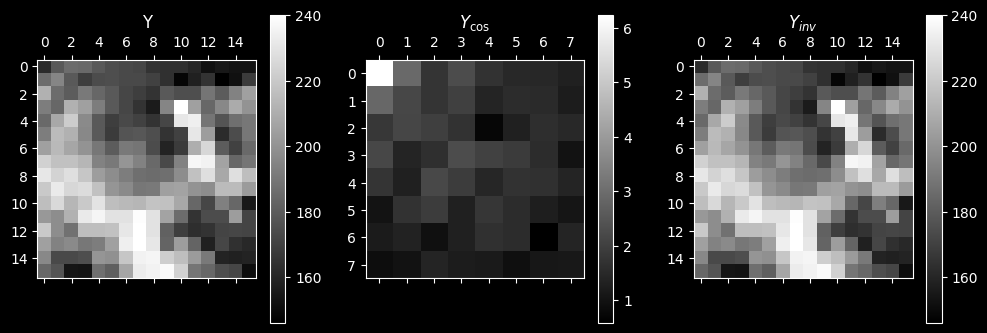

In [204]:
Y = mb[:,:,0]
Y_cos = forward_dct(Y)
Y_inv = inverse_dct(Y_cos)

# Generate side by side subplots
fig, ax = plt.subplots(1,3, figsize=(12,4))
a = ax[0].matshow(Y, label='Y', cmap='grey')
ax[0].title.set_text('Y')
fig.colorbar(a, ax=ax[0])
b = ax[1].matshow(np.abs(Y_cos[0:8,0:8])**(1/4), label='Y_cos', cmap='grey')
fig.colorbar(b, ax=ax[1])
ax[1].title.set_text('$Y_{\\cos}$')
c = ax[2].matshow(Y_inv, label='Y_inv', cmap='grey')
fig.colorbar(c, ax=ax[2])
ax[2].title.set_text('$Y_{inv}$')
plt.show()

In [217]:
QY = np.array([
    [16,11,10,16, 24, 40, 51, 61],
    [12,12,14,19, 26, 58, 60, 55],
    [14,13,16,24, 40, 57, 69, 56],
    [14,17,22,29, 51, 87, 80, 62],
    [18,22,37,56, 68,109,103, 77],
    [24,35,55,64, 81,104,113, 92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,103, 99]
])

QC = np.array([
    [17,18,24,47,99,99,99,99],
    [18,21,26,66,99,99,99,99],
    [24,26,56,99,99,99,99,99],
    [47,66,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99],
    [99,99,99,99,99,99,99,99]
])

In [222]:
def quantize_luma(Y):
    blocks = []
    for i in range(0, 16, 8):
        for j in range(0, 16, 8):
            block = Y[i:i+8, j:j+8]
            block = (block / QY).round()
            blocks.append(block)
    return np.block([[blocks[0], blocks[1]], [blocks[2], blocks[3]]])

def inverse_quantize_luma(Y):
    blocks = []
    for i in range(0, 16, 8):
        for j in range(0, 16, 8):
            block = Y[i:i+8, j:j+8]
            block = block * QY
            blocks.append(block)
    return np.block([[blocks[0], blocks[1]], [blocks[2], blocks[3]]])

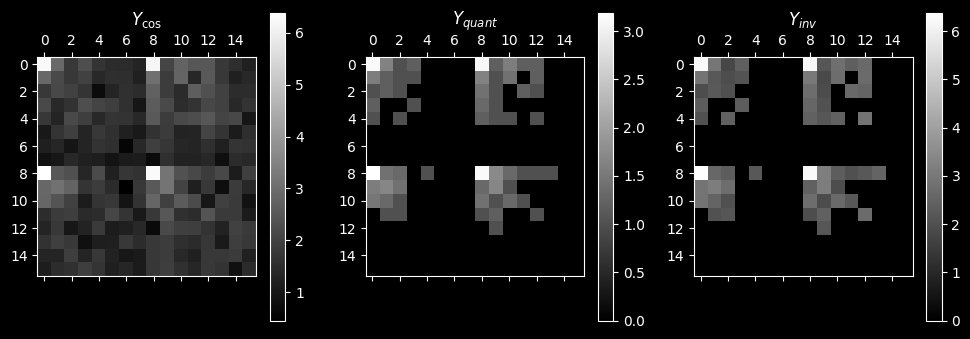

In [227]:
Y_quant = quantize_luma(Y_cos)
Y_inv = inverse_quantize_luma(Y_quant)

fig, ax = plt.subplots(1,3, figsize=(12,4))
a = ax[0].matshow(np.abs(Y_cos)**(1/4), label='Y_cos', cmap='grey')
ax[0].title.set_text('$Y_{\\cos}$')
fig.colorbar(a, ax=ax[0])
b = ax[1].matshow(np.abs(Y_quant)**(1/4), label='Y_quant', cmap='grey')
fig.colorbar(b, ax=ax[1])
ax[1].title.set_text('$Y_{quant}$')
c = ax[2].matshow(np.abs(Y_inv)**(1/4), label='Y_inv', cmap='grey')
fig.colorbar(c, ax=ax[2])
ax[2].title.set_text('$Y_{inv}$')
plt.show()